<a href="https://colab.research.google.com/github/DulithMH/fraud-detection/blob/main/fraud_dection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

Using Colab cache for faster access to the 'creditcardfraud' dataset.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

load the dataset

In [ ]:
import os

file_path = os.path.join(path, 'creditcard.csv')
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


cheak the balance of the dataset

In [ ]:
fraud_percentage = (df['Class'].value_counts()[1] / len(df)) * 100
print(f"Fraudulent transactions percentage: {fraud_percentage:.2f}%")

Fraudulent transactions percentage: 0.17%


now cheak the null value count

In [ ]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


then i'm going to define X & Y

In [ ]:
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

Now i'm going to split the dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now im going to do smote for the trsining set

In [ ]:
from imblearn.over_sampling import SMOTE

# Get the count of the majority class (Class 0)
majority_class_count = y_train.value_counts()[0]

# Calculate the target number of samples for the minority class (1/10th of majority)
minority_target_count = int(majority_class_count / 10)

sm = SMOTE(sampling_strategy={1: minority_target_count}, random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

add Random Forest to this

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score

# 1. Initialize the model
# n_jobs=-1 uses all your computer's processors to speed up the work
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Train using the RESAMPLED data
rf_model.fit(X_resampled, y_resampled)

# 3. Predict on the ORIGINAL Test set (Never use resampled data for testing!)
y_pred = rf_model.predict(X_test)
y_probs = rf_model.predict_proba(X_test)[:, 1]

cheaking f1 score


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



Visualizing confusing Matrix


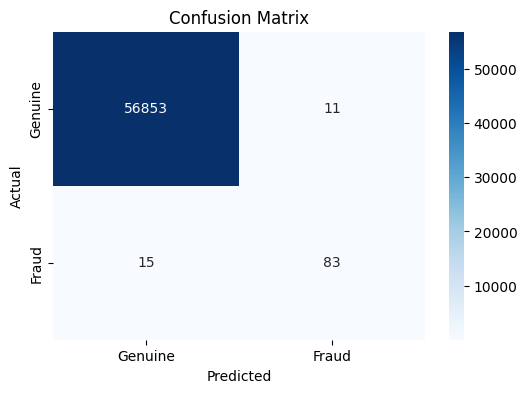

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Plot the Precision-Recall Curve

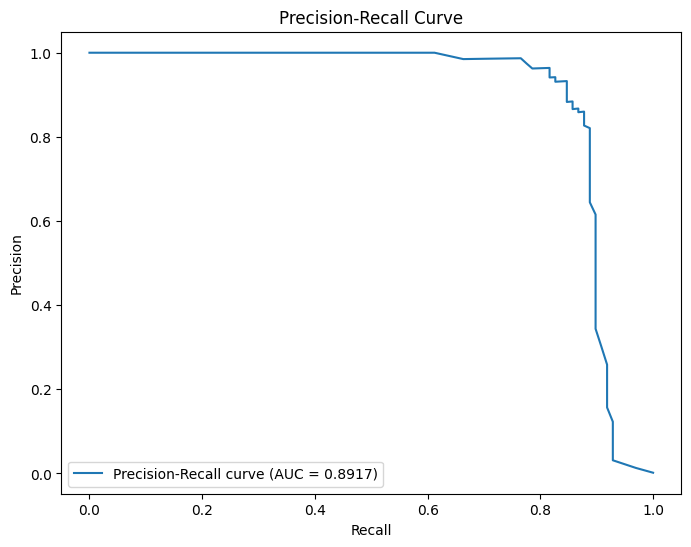

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
auc_score = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

feature impotence


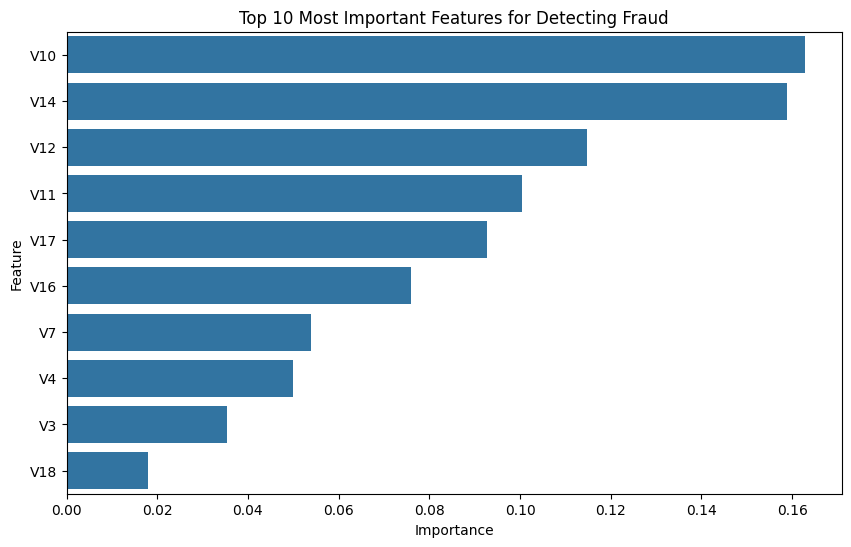

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get importance levels
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Most Important Features for Detecting Fraud')
plt.show()

In [ ]:
# Example: Changing the threshold to be more aggressive in catching fraud
new_threshold = 0.3
y_pred_new = (y_probs >= new_threshold).astype(int)

# Check the new Confusion Matrix to see if you caught more than 83 frauds
print(confusion_matrix(y_test, y_pred_new))

[[56844    20]
 [   11    87]]


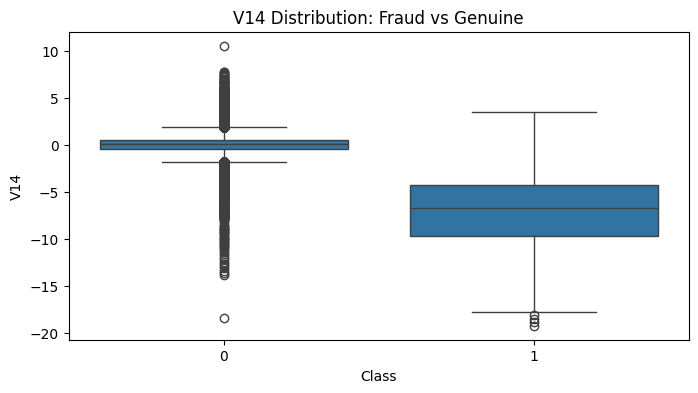

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare distributions of the most important feature
plt.figure(figsize=(8,4))
sns.boxplot(x='Class', y='V14', data=df)
plt.title('V14 Distribution: Fraud vs Genuine')
plt.show()

Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1. Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 2. Initialize the Randomized Search
# n_iter=10 means it will try 10 random combinations
# scoring='average_precision' focuses on the AUPRC as recommended
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='average_precision'
)

# 3. Fit the model to your resampled training data
rf_random.fit(X_resampled, y_resampled)

# 4. Get the best parameters and the best model
print(f"Best Parameters: {rf_random.best_params_}")
best_rf_model = rf_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}


Evaluate the Optimized Model

In [ ]:
# Predict with the optimized model
y_pred_optimized = best_rf_model.predict(X_test)
y_probs_optimized = best_rf_model.predict_proba(X_test)[:, 1]

# Check if the AUPRC improved
from sklearn.metrics import average_precision_score
new_auprc = average_precision_score(y_test, y_probs_optimized)
print(f"Optimized AUPRC: {new_auprc:.4f}")

Optimized AUPRC: 0.8937


In [ ]:
print("--- Optimized Model Classification Report ---")
print(classification_report(y_test, y_pred_optimized))

--- Optimized Model Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.86      0.88        98

    accuracy                           1.00     56962
   macro avg       0.95      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962



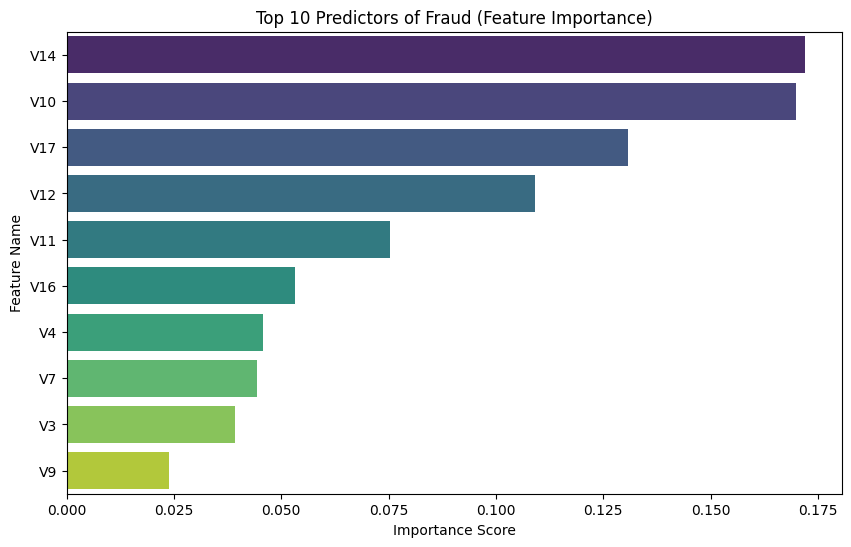

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract importance from the best model
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# 2. Organize into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Plot the top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Predictors of Fraud (Feature Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()